In [1]:
import numpy as np
import copy as copy
from matplotlib import pyplot as plt
# can be 'PIN' or 'ROLLER'
class Joint(object):
    def __init__(self, id=0, x=0, y=0):
        self.id=id
        self.x=x
        self.y=y

def calculate_distance(start_joint, end_joint):
    dx = end_joint.x - start_joint.x
    dy = end_joint.y - start_joint.y
    return np.abs(dx*dx + dy*dy)
# list of joints: dictionary {ID : {Joint}  }, 
# list of edges: tuples (A, B)    
    
class Truss(object):
    def __init__(self, edgeList=[], 
                 joints=[], 
                 fixed_joint='', 
                 roller_joint='', 
                 center_joint='', 
                 dict_of_symmetric_joints={}, 
                 reduced_joint_list =[]):
        self.edgeList = edgeList
        self.joints = joints
        self.fixed_joint = fixed_joint
        self.roller_joint = roller_joint
        self.center_joint = center_joint
        self.dict_of_symmetric_joints = dict_of_symmetric_joints        
        self.reduced_joint_list = reduced_joint_list

        self.member_cross_area = 19.625e-4 #m^2
        self.member_density = 8050 #kg / m^3
        self.joint_mass = 5 #kg
        self.jointDict = {}
        
        
        for joint in self.joints:
            self.jointDict[joint.id] = joint
        
    def calculate_mass(self):
        total_length = 0
        num_joints = len(self.joints)
        for edge in self.edgeList:
            joint_1 = self.jointDict[edge[0]]
            joint_2 = self.jointDict[edge[1]]
            length = calculate_distance(joint_1, joint_2)
            total_length += length
        mass = total_length * self.member_cross_area * self.member_density
        mass += num_joints * self.joint_mass
        return mass

    def print_truss(self):
        for joint in self.joints:
            print(joint.id, joint.x, joint.y)
        for edge in self.edgeList:
            print(edge)
    
    def print_joints(self):
        for joint in self.joints:
            print(joint.id, joint.x, joint.y)
    def print_edges(self):
        for edge in self.edgeList:
            print(edge)
    
    def update_joint(self, joint_id, x, y):
        new_joint = Joint(joint_id, x, y)
        self.jointDict[joint_id] = new_joint
        for i in range(len(self.joints)):
            if self.joints[i].id == joint_id:
                self.joints[i] = new_joint
                return

    def num_joints(self):
        return len(self.joints)
    
    def draw_truss(self):
        for edge in self.edgeList:
            id1 = edge[0]
            id2 = edge[1]
            joint1 = self.jointDict[id1]
            joint2 = self.jointDict[id2]
            x = [joint1.x, joint2.x]
            y = [joint1.y, joint2.y]
            plt.plot(x, y, 'go-', linewidth=2)
            #plt.ylim((-1,3))
        plt.show()
            

In [2]:
# truss solving function:
# takes in:
# TRUSS object (list of nodes, list of edges)
# list of forces
# AppliedForces : (JointID, magnitude, direction (in y direction))
def solve_forces(appliedForces, truss):
    numAppliedForces = len(appliedForces)
    numJoints = len(truss.joints)
    numReactions = 3 # 2 (Fx, Fy) at fixed joint, 1 (Fy) at roller
    numEdges = len(truss.edgeList)
    numEquations = numAppliedForces + numEdges + numReactions
    M = np.zeros((numEquations, numEquations))
    #M system of equations to solve [<applied forces> .... <x forces in joints> <y forces in joints> ]
    #F : vector of forces to solve for [<applied forces>, <forces in beams>, <reactions>]
    
    E = np.zeros((numEquations, 1)) #solution to system of equations M*F = E
    #populate rows for  E 
    for i in range(numAppliedForces):
        E[i] = appliedForces[i][1]
        M[i][i] = 1

    i = 0 
    for i in range(numJoints):
        joint = truss.joints[i]
        jointId = joint.id
        row = i*2 + numAppliedForces
        for j in range(len(appliedForces)):
            col = j
            if(appliedForces[j][0] == jointId):
                M[row][col] = 1 # Force:(jointId, magnitude)
        
        for j in range(len(truss.edgeList)):
            col = j+numAppliedForces
            edge = truss.edgeList[j]
            otherJointId = None
            if(edge[0] == jointId):
                otherJointId = edge[1]
            elif(edge[1] == jointId):
                otherJointId = edge[0]
            if(otherJointId != None):
                otherJoint = truss.jointDict[otherJointId]
                x1 = joint.x
                y1 = joint.y
                x2 = otherJoint.x
                y2 = otherJoint.y
                dx = x2 - x1
                dy = y2 - y1
                theta = np.pi/2
                if(dx != 0):   
                    theta = np.abs(np.arctan(dy/dx))
                x_multiplier = np.sign(dx) * np.cos(theta)
                y_multiplier = np.sign(dy) * np.sin(theta)
                
                M[row][col] = y_multiplier
                M[row+1][col] = x_multiplier
        if(joint.id == truss.fixed_joint):
            M[row][numEquations - 3] = 1 # reaction, assume in positive direction
            M[row + 1][numEquations - 2] = 1 #y reaction, assume in positive direction
        if(joint.id == truss.roller_joint):
            M[row][numEquations - 1] = 1
    
    F = np.linalg.solve(M, E)
    F = np.around(F,2)
    return M, E, F

In [3]:
#joint_x_list = [0, 0.5, 1]
#joint_y_list = [0, 0.866, 0]
#jointIds = ['A', 'B', 'C']
joint_x_list = [0, 1, 2, 3, 4]
joint_y_list = [0, 1, 0, 1, 0]
jointIds = ['A', 'B', 'C', 'D', 'E']
jointList = []
for i in range(len(jointIds)):
    joint = Joint(jointIds[i],joint_x_list[i],joint_y_list[i]);
    jointList.append(joint)

edge_list = [('A', 'B'), ('B', 'C'), ('A', 'D'), ('D', 'E'), ('D', 'B'), ('E','C'), ('B', 'E')]

truss = Truss(edge_list, jointList, 'A', 'E')
mass = truss.calculate_mass()
print(mass)

562.13625


In [4]:
applied_force_list = [('B', -100)] # 500 Newtons
M, E, F = solve_forces(applied_force_list, truss)
print(M)
print(F)

[[ 1.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.          0.70710678  0.          0.31622777  0.          0.          0.
   0.          1.          0.          0.        ]
 [ 0.          0.70710678  0.          0.9486833   0.          0.          0.
   0.          0.          1.          0.        ]
 [ 1.         -0.70710678 -0.70710678  0.          0.          0.          0.
  -0.31622777  0.          0.          0.        ]
 [ 0.         -0.70710678  0.70710678  0.          0.          1.          0.
   0.9486833   0.          0.          0.        ]
 [ 0.          0.          0.70710678  0.          0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.          0.         -0.70710678  0.          0.          0.          1.
   0.          0.          0.          0.        ]
 [ 0.          0.          0.         -0.31622777 -0.70710678  0.          0.
   0.          0.  

In [5]:
import operator

def sort_by_x(list_of_nodes):
    list_of_nodes.sort(key = operator.attrgetter('x'))
    
def getKey(item):
    return item[1]

def refine(x, y, std):
    x_refined = np.random.normal(x, std)
    y_refined = np.random.normal(y, std)
    return np.round(x_refined,2), np.round(y_refined,2)

def sorted_list_of_nodes_by_distances(joint_list, start_joint):
    distance_list = []
    for joint in joint_list:
        if(joint.id == start_joint.id):
            continue
        r = calculate_distance(start_joint, joint)
        distance_list.append((joint.id, r))
    return sorted(distance_list, key = getKey)

class TrussGenerator:
    def __init__(self, width, max_height, min_height, min_edge_length):
        self.width = width
        self.x_min = -width/2
        self.x_max = width/2
        self.max_height = max_height
        self.min_height = min_height
        self.min_edge_length = min_edge_length
        self.ascii_offset = 65
        self.joint_list = []
        self.dict_of_symmetric_joints = {}
        self.center_joint_id = ''
        self.pin_joint_id = ''
        self.roller_joint_id = ''
        self.list_of_edges = []
        self.reduced_joint_list = []
        self.connected_node_table = {}
    
    def reset(self):
        self.joint_list = []
        self.dict_of_symmetric_joints = {}
        self.center_joint_id = ''
        self.pin_joint_id = ''
        self.roller_joint_id = ''
        self.list_of_edges = []
        self.reduced_joint_list = []
        self.connected_node_table = {}
    
    def calculate_distance_by_id(self, id1, id2):
        joint1 = [joint for joint in self.joint_list if joint.id == id1][0]
        joint2 = [joint for joint in self.joint_list if joint.id == id2][0]
        return calculate_distance(joint1, joint2)
        
    def add_joint_to_list(self, joint_list, x, y):
        index = len(joint_list)
        joint = Joint(chr(index + self.ascii_offset), x, y)
        joint_list.append(joint)
        return joint.id

    def add_symmetric_pair_of_joints(self, id1, id2):
        self.dict_of_symmetric_joints[id1] = id2
        self.dict_of_symmetric_joints[id2] = id1
        self.reduced_joint_list.append(id1)

    def generate_nodes(self, num_joints):
        joint_list = []
        index = 0
        x_end = width/2
        x_start = -width/2
        # place fixed joints 
        self.pin_joint_id = self.add_joint_to_list(joint_list, x_start, 0)
        self.roller_joint_id = self.add_joint_to_list(joint_list, x_end, 0)
        self.add_symmetric_pair_of_joints(self.pin_joint_id, self.roller_joint_id)
        # place central joints
        is_even = False
        num_central_joints = 1
        if(num_joints % 2 == 0):
            is_even = True
            num_central_joints = 2
        #place first central joint
        y_coarse = np.random.uniform(self.min_height,self.max_height)
        y_refined = np.random.normal(y_coarse, min_edge_length/2)
        self.center_joint_id = self.add_joint_to_list(joint_list, 0,y_refined)
        self.add_symmetric_pair_of_joints(self.center_joint_id, self.center_joint_id)
        if(is_even):
            y_coarse_2 = np.random.uniform(min_height, max_height)
            if(y_coarse_2 == y_coarse):
                y_coarse_2 = (y_coarse + 1) % (self.max_height - self.min_height) + self.min_height
            y_refined_2 = np.random.normal(y_coarse, min_edge_length/2)
            center2_id = self.add_joint_to_list(joint_list, 0,y_refined_2)
            self.add_symmetric_pair_of_joints(center2_id, center2_id)

        min_length = self.min_edge_length
        x_grid_size = (self.width / 2) / self.min_edge_length - 2
        y_grid_size = (self.max_height - self.min_height) / self.min_edge_length       
        
        total_positions = x_grid_size * y_grid_size
        if(total_positions < num_joints):
            min_length = min_length / 2
        
        #generate list of tuples with all possible positions
        possible_position_list = []
        for x in np.arange(min_length, width/2 - min_length, min_length):
            for y in np.arange(min_height, max_height, min_length):
                possible_position_list.append((x, y))
        
        num_remaining_joints = int((num_joints - 2 - num_central_joints) / 2)
        std = self.min_edge_length / 4
        for i in range(num_remaining_joints):
            list_size = len(possible_position_list)
            index = np.random.randint(0,list_size)
            x = possible_position_list[index][0]
            y = possible_position_list[index][1]
            x, y = refine(x,y, std)
            id1 = self.add_joint_to_list(joint_list, x, y)
            possible_position_list.pop(index)
            # mirror the joint
            x_mirrored = -x
            id2 = self.add_joint_to_list(joint_list, x_mirrored, y)
            self.add_symmetric_pair_of_joints(id1, id2)

        self.joint_list = joint_list
        return joint_list
    
    def connect_nodes(self, id1, id2):
        are_connected = self.check_are_connected(id1, id2)
        if(are_connected):
            return
        self.connected_node_table[id1].append(id2)
        self.connected_node_table[id2].append(id1)
        edge = (id1, id2)
        self.list_of_edges.append(edge)
    
    def mirror_connection(self, id1, id2):
        mirror_id_1 = self.dict_of_symmetric_joints[id1]
        mirror_id_2 = self.dict_of_symmetric_joints[id2]
        self.connect_nodes(mirror_id_1, mirror_id_2)
    
    def check_joint_forms_sufficient_triangles(self, jointId):
        connections = self.connected_node_table[jointId]
        unvisited_joints = copy.deepcopy(connections)
        num_desired_triangles = len(connections) - 1
        num_triangles = 0
        
        for joint1_id in connections:
            joint1_connections = self.connected_node_table[joint1_id]
            for joint2_id in joint1_connections:
                if(joint2_id in unvisited_joints):
                    num_triangles = num_triangles+1
            unvisited_joints.remove(joint1_id)
            
        missing_connections = num_desired_triangles - num_triangles
        is_sufficient = num_triangles == num_desired_triangles
        return is_sufficient, num_triangles, missing_connections
   
    def check_are_connected(self,id1, id2):
        nodes_1 = self.connected_node_table[id1]
        nodes_2 = self.connected_node_table[id2]
        id1_in_nodes2 = id1 in nodes_2
        id2_in_nodes1 = id2 in nodes_1
        
        tuple1 = (id1, id2)
        tuple2 = (id2, id1)
        tuple1_in_list = tuple1 in self.list_of_edges
        tuple2_in_list = tuple2 in self.list_of_edges
        #if(tuple1_in_list and tuple2_in_list):
            #print("error - edge repeated")
        
        edge_in_list = tuple1_in_list or tuple2_in_list
        
        if(id1_in_nodes2 and id2_in_nodes1 and edge_in_list):
            return True
        #if(id1_in_nodes2 or id2_in_nodes1):
            #print("error in connection table", id1, id2)        
        
        return False
        
    def fix_under_connected_joint(self, jointId, num_additional_connections):
        if(num_additional_connections < 1):
            return
        connections = self.connected_node_table[jointId]
        unvisited_joints = copy.deepcopy(connections)
        possible_new_edges = []
        for joint1_id in connections:
            for joint2_id in unvisited_joints:
                if(joint1_id == joint2_id):
                    continue
                are_connected = self.check_are_connected(joint1_id, joint2_id)
                if(not are_connected):
                    distance = self.calculate_distance_by_id(joint1_id, joint2_id)
                    possible_new_edges.append((joint1_id, joint2_id, distance))
            unvisited_joints.remove(joint1_id)
        possible_new_edges.sort(key=lambda tup: tup[2])
        
        for i in range(num_additional_connections):
            id1 = possible_new_edges[i][0]
            id2 = possible_new_edges[i][1]
            self.connect_nodes(id1, id2)
            self.mirror_connection(id1, id2)
    
    def check_and_fix_under_connected_joints(self):
        for joint_id in self.reduced_joint_list:
            is_sufficient, num_triangles, num_missing_edges = self.check_joint_forms_sufficient_triangles(joint_id)
            if(not is_sufficient):
                self.fix_under_connected_joint(joint_id, num_missing_edges)
    
    def build_connections(self):
        sort_by_x(self.joint_list)
        
        self.list_of_edges = []
        self.connected_node_table = {}
        #initialize table with empty lists
        for joint in self.joint_list:
            self.connected_node_table[joint.id] = []
        
        num_nodes = len(self.joint_list)
        num_desired_connections = 2*num_nodes - 3
        if(num_desired_connections < 3):
            return
        even_num = False
        if(num_nodes % 2 == 0):
            even_num = True
        
        index_start = 0
        index_end = index_end = int((num_nodes - 1)/2)
        if(even_num):
            index_end = int(num_nodes - 2)/2
        
        index_center_node_start = int(index_end)
        index_center_node_end = int(index_end)
        if(even_num):
            index_center_node_end = int(index_center_node_start + 1)
        
        num_connections = 0
        subset_of_nodes = self.joint_list[0:index_center_node_end]
        
        
        if(even_num): #connect 2 center joints
            joint1_id = self.joint_list[index_center_node_start].id
            joint2_id = self.joint_list[index_center_node_start+1].id
            self.connect_nodes(joint1_id, joint2_id)
        else: #connect 2 joints closest to center joint
            joint1_id = self.joint_list[index_center_node_start - 1].id
            joint2_id = self.dict_of_symmetric_joints[joint1_id]
            self.connect_nodes(joint1_id, joint2_id)

        for node in subset_of_nodes:
            list_of_nodes_by_distance = sorted_list_of_nodes_by_distances(self.joint_list, node)
            closest_node_id = list_of_nodes_by_distance[0][0]
            next_closest_node_id = list_of_nodes_by_distance[1][0]
            # check if closest node already connected
            if(closest_node_id not in self.connected_node_table[node.id]):
                self.connect_nodes(node.id, closest_node_id)
                self.mirror_connection(node.id, closest_node_id)
            # check if next closest node is already connected 
            if(next_closest_node_id not in self.connected_node_table[node.id]):
                self.connect_nodes(node.id, next_closest_node_id)
                self.mirror_connection(node.id, next_closest_node_id)
        
        num_edges = len(self.list_of_edges)
        if(num_edges < num_desired_connections):
            #print("fixing underconnected joints", len(self.list_of_edges))
            self.check_and_fix_under_connected_joints();
        #if(num_edges > num_desired_connections):
            #print("too many connections", len(self.list_of_edges))
            #print(self.connected_node_table)
        succesful = (len(self.list_of_edges) == num_desired_connections)
        return self.list_of_edges, self.connected_node_table, succesful

    def generate_truss(self, num_joints):
        self.reset()
        self.generate_nodes(num_joints)
        self.build_connections()
        
        return Truss(self.list_of_edges, 
                     self.joint_list, 
                     self.pin_joint_id, 
                     self.roller_joint_id, 
                     self.center_joint_id,
                     self.dict_of_symmetric_joints, 
                     self.reduced_joint_list)

In [6]:
# test generate_truss()
width = 4
max_height = 2
min_height = 0
min_edge_length = 0.5

truss_generator = TrussGenerator(width, max_height, min_height, min_edge_length)
num_joints = 5
truss = truss_generator.generate_truss(num_joints)
for edge in truss.edgeList:
    print(edge)
    
for joint in truss.joints:
    print(joint.id, joint.x, joint.y)

('E', 'D')
('A', 'E')
('B', 'D')
('A', 'C')
('B', 'C')
('E', 'C')
('D', 'C')
A -2.0 0
E -0.95 -0.06
C 0 0.4002233023879432
D 0.95 -0.06
B 2.0 0


In [11]:
def evaluate_fitness(truss, applied_force, member_strength, num_applied_forces=1):
    center_joint = truss.center_joint
    
    applied_forces = [(center_joint, applied_force)]
    M, E, F = solve_forces(applied_forces, truss)
    length_F = len(F)
    forces_in_beams = []
    
    for i in range(num_applied_forces,length_F - 3):
        force = F[i][0]
        forces_in_beams.append(np.abs(force))
    max_force_in_member = max(forces_in_beams)
    safety_factor = member_strength / max_force_in_member
    mass = truss.calculate_mass()
    # maybe should calculate maximum mass?
    fitness = safety_factor*100 / (mass)
    return fitness

In [12]:
# test evaluate_fitness:
fitness_score = evaluate_fitness(truss, -500, 100, 1)
print(fitness_score)

0.0324519144172


In [13]:
def calculate_dx_dy(r, theta):
    dx = r * np.cos(theta)
    dy = r * np.sin(theta)
    return dx, dy

class Constraints:
    def __init__(self,  
                 width, 
                 max_height, 
                 min_height, 
                 min_edge_length, 
                 min_number_joints, 
                 max_number_joints,
                 load=-100,
                 member_strength=490):
        self.width = width
        self.max_height = max_height
        self.min_height = min_height
        self.min_edge_length = min_edge_length
        self.min_number_joints = min_number_joints
        self.max_number_joints = max_number_joints
        self.load = load
        self.member_strength = member_strength

class MutationParameters:
    def __init__(self, 
                 num_iterations_per_joint, 
                 num_joint_mutation_directions, 
                 min_r = 0.2, 
                 max_r = 0.5,
                 iterations_per_truss = 6):
        self.num_joint_mutation_directions = num_joint_mutation_directions
        self.num_iterations_per_joint = num_iterations_per_joint
        self.min_r = min_r
        self.max_r = max_r
        self.num_iterations_per_truss = iterations_per_truss
        self.dr = max_r

class Population:
    def generate_population(self):
        start = self.constraints.min_number_joints
        end = self.constraints.max_number_joints + 1
        truss_generator = TrussGenerator(self.constraints.width, 
                                         self.constraints.max_height, 
                                         self.constraints.min_height, 
                                         self.constraints.min_edge_length)
        
        for num_joints in range(start, end):
            new_truss = truss_generator.generate_truss(num_joints)
            self.candidate_list.append(new_truss)
    
    def initialize_survivor_list(self, fitness_scores):
        self.survivor_list = []
        for i in range(len(fitness_scores)):
            truss_score_tuple = (self.candidate_list[i], fitness_scores[i])
            self.survivor_list.append(truss_score_tuple)
    
    def evaluate_population_fitness(self):
        truss_score_list = []
        fitness = 0
        count = 0
        for truss in self.candidate_list:
            try:
                fitness = evaluate_fitness(truss, 
                                        self.constraints.load, 
                                        self.constraints.member_strength, 1)
            except:
                fitness = 0
                #print("failed to solve truss ", count)
                #print("Truss Joints")
                #truss.print_joints()
                #print("Truss Edges")
                #truss.print_edges()
            count = count+1
            truss_score_list.append(fitness)
        return truss_score_list
    
    def __init__(self, constraints, max_survivors=30):
        self.constraints = constraints
        self.max_survivors = int(max_survivors)
        self.candidate_list = [] 
        self.survivor_list = [] #tuple of truss object and fitness score
        self.mutation_parameters = MutationParameters(1, 4)
        self.generate_population()
        truss_score_list = self.evaluate_population_fitness()
        self.fitness_threshold = min(truss_score_list)
        self.initialize_survivor_list(truss_score_list)

    def crop_population(self):
        self.survivor_list = [] #tuple of truss object and fitness score
        fitness_score_list = self.evaluate_population_fitness()
        for i in range(len(fitness_score_list)):
            score = fitness_score_list[i]
            if(score < self.fitness_threshold):
                continue
            truss_score_tuple = (self.candidate_list[i], score)
            self.survivor_list.append(truss_score_tuple)
        
        self.survivor_list.sort(key=lambda tup: tup[1], reverse=True)
        if(len(self.survivor_list) > self.max_survivors):
            self.survivor_list = self.survivor_list[:self.max_survivors]
        
        index_of_last_element = len(self.survivor_list) - 1
        self.fitness_threshold = self.survivor_list[index_of_last_element][1]
        #reset population_list
        self.candidate_list = []
    
    def mutate_central_joint(self, truss, joint_id, min_r, max_r):
        list_of_children = []
        dy = np.random.uniform(min_r, max_r)
        new_child_1 = copy.deepcopy(truss)
        new_child_2 = copy.deepcopy(truss)
        
        joint = new_child_1.jointDict[joint_id]
        y_new1 = joint.y + dy
        y_new2 = joint.y - dy

        new_child_1.update_joint(joint_id, joint.x, y_new1)
        new_child_2.update_joint(joint_id, joint.x, y_new2)
        return [new_child_1, new_child_2]
    
    def mutate_all_joints(self, truss, r):
        child = copy.deepcopy(truss)
        for joint_id in child.reduced_joint_list:
            if(joint_id == truss.fixed_joint or joint_id == truss.roller_joint):
                continue
            
            #r = np.random.uniform(min_r, max_r)
            theta = np.random.uniform(0, 2*np.pi)
            dx, dy = calculate_dx_dy(r, theta)
            x_new = joint.x + dx
            y_new = joint.y + dy
            symmetric_joint_id = child.dict_of_symmetric_joints[joint_id]
            if(symmetric_joint_id == joint_id):
                x_new = 0
            if(y_new < self.constraints.min_height):
                y_new = min_height
            if(y_new > self.constraints.max_height):
                y_new = max_height
            
            child.update_joint(joint_id, x_new, y_new)
            child.update_joint(symmetric_joint_id, -x_new, y_new)
        return child
    
    def spawn_children(self, truss):
        for i in range(self.mutation_parameters.num_iterations_per_truss):
            child = self.mutate_all_joints(truss, self.mutation_parameters.dr)
            self.candidate_list.append(child)
    
    def generate_single_joint_mutations(self, truss, joint_id, num_directions, min_r, max_r):
        list_of_children = []
        if(num_directions < 1):
            print("error, num_directions cannot be less than 1")
        # construct table
        angle_increment = 2*np.pi / num_directions
        direction_table = []
        for i in range(0, num_directions):
            start_angle = i * angle_increment
            end_angle = (i+1) * angle_increment
            direction_table.append((start_angle, end_angle))
        
        #alternately use a uniform distribution
        for direction in direction_table:
            r = np.random.uniform(min_r, max_r)
            spread = angle_increment
            target_direction = direction[0]
            theta = np.random.uniform(direction[0], direction[1])
            
            new_child = copy.deepcopy(truss)
            joint = new_child.jointDict[joint_id]
            dx, dy = calculate_dx_dy(r, theta)
            x_new = joint.x + dx
            y_new = joint.y + dy
            symmetric_joint_id = new_child.dict_of_symmetric_joints[joint_id]
            
            new_child.update_joint(joint_id, x_new, y_new)
            new_child.update_joint(symmetric_joint_id, -x_new, y_new)
            list_of_children.append(new_child)    
        
        return list_of_children    
    
    def add_children_to_population(self, list_of_children):
        for child in list_of_children:
            self.candidate_list.append(child)
        
    def spawn_children_single_joint_mutation(self, truss):
        for joint_id in truss.reduced_joint_list:
            if(joint_id == truss.fixed_joint or joint_id == truss.roller_joint):
                continue
            #check if joint is central - if it is we need to preserve symmetry during mutation
            if(truss.dict_of_symmetric_joints[joint_id] == joint_id):
                new_children = self.mutate_central_joint(truss, joint_id, self.mutation_parameters.min_r, self.mutation_parameters.max_r)
                self.add_children_to_population(new_children)
            else:
                for i in range(self.mutation_parameters.num_iterations_per_joint):
                    new_children = self.generate_single_joint_mutations(truss, 
                                                                   joint_id, 
                                                                   self.mutation_parameters.num_joint_mutation_directions,
                                                                   self.mutation_parameters.min_r,
                                                                   self.mutation_parameters.max_r)
                    self.add_children_to_population(new_children)
    
    def balance_diversity_of_candidates(self):
        histogram = {}
        for i in range(self.constraints.min_number_joints, self.constraints.max_number_joints + 1):
            histogram[i] = 0
        
        for candidate in population.candidate_list:
            num_joints = candidate.num_joints()
            histogram[num_joints] +=1
        
        print(histogram)
        max_count = max(histogram.values())
        print(max_count)
        
        for joint_num in range(self.constraints.min_number_joints, self.constraints.max_number_joints + 1):
            #print("balancing number for", joint_num)
            num_existing = histogram[joint_num]
            #print("Existing population", num_existing)
            num_to_add = max_count - num_existing
            #print("Number to add", num_to_add)
            if(num_to_add < 1):
                continue
            for i in range(num_to_add):
                new_truss = truss_generator.generate_truss(joint_num)
                self.candidate_list.append(new_truss)
    
    def spawn_new_generation(self):
        self.candidate_list = []
        for survivor in self.survivor_list:
            truss = survivor[0]
            self.candidate_list.append(truss)
            #self.spawn_children_single_joint_mutation(survivor[0])
            self.spawn_children(truss)
        self.balance_diversity_of_candidates();
                
        
    def print_population(self):
        count = 0
        for truss in self.candidate_list:
            print("child no. ", count)
            truss.print_joints()
            count +=1
            print("\n")
        
        

In [14]:
# Test generate population
width = 4
max_height = 1
min_height = 0
min_edge_length = 0.5
min_number_joints = 3
max_number_joints = 7

constraints = Constraints(width,max_height,min_height, min_edge_length, min_number_joints, max_number_joints)
population = Population(constraints)
for truss in population.candidate_list:
    truss.print_joints()
    print('num reduced joints', len(truss.reduced_joint_list), '\n')

A -2.0 0
C 0 1.2539296397474504
B 2.0 0
num reduced joints 2 

A -2.0 0
C 0 0.6544532293630824
D 0 0.3600389341850478
B 2.0 0
num reduced joints 3 

A -2.0 0
E -0.28 0.96
C 0 0.8520704335860041
D 0.28 0.96
B 2.0 0
num reduced joints 3 

A -2.0 0
F -0.51 0.85
C 0 0.37612627403920074
D 0 0.18849980575934583
E 0.51 0.85
B 2.0 0
num reduced joints 4 

A -2.0 0
E -1.3 0.96
G -0.14 0.23
C 0 0.25154155299022846
F 0.14 0.23
D 1.3 0.96
B 2.0 0
num reduced joints 4 



In [15]:
# Test mutate all joints in truss
parent = population.candidate_list[1]
parent.print_joints()
child = population.mutate_all_joints(parent, 0.1)
child.print_joints()

A -2.0 0
C 0 0.6544532293630824
D 0 0.3600389341850478
B 2.0 0
A -2.0 0
C 0 0.0947652216689
D 0 0.095672570053
B 2.0 0


In [16]:
# Test mutate single joints in truss

children = population.generate_single_joint_mutations(population.candidate_list[0], 'A', 4, 0.1, 0.5)
count = 1
for child in children:
    print("truss no. ", count)
    child.print_joints()
    count = count+1
    print("\n")

truss no.  1
A -1.92800278742 0.280226693847
C 0 1.2539296397474504
B 1.92800278742 0.280226693847


truss no.  2
A -2.3101745439 0.0380419188542
C 0 1.2539296397474504
B 2.3101745439 0.0380419188542


truss no.  3
A -2.17308833624 -0.453585235745
C 0 1.2539296397474504
B 2.17308833624 -0.453585235745


truss no.  4
A -1.97571191042 -0.133970079608
C 0 1.2539296397474504
B 1.97571191042 -0.133970079608




In [17]:
# test spawn children
print("before spawning children")
population.print_population()

population.spawn_children_single_joint_mutation(population.candidate_list[0])
print("after spawning children")
population.print_population()

before spawning children
child no.  0
A -2.0 0
C 0 1.2539296397474504
B 2.0 0


child no.  1
A -2.0 0
C 0 0.6544532293630824
D 0 0.3600389341850478
B 2.0 0


child no.  2
A -2.0 0
E -0.28 0.96
C 0 0.8520704335860041
D 0.28 0.96
B 2.0 0


child no.  3
A -2.0 0
F -0.51 0.85
C 0 0.37612627403920074
D 0 0.18849980575934583
E 0.51 0.85
B 2.0 0


child no.  4
A -2.0 0
E -1.3 0.96
G -0.14 0.23
C 0 0.25154155299022846
F 0.14 0.23
D 1.3 0.96
B 2.0 0


after spawning children
child no.  0
A -2.0 0
C 0 1.2539296397474504
B 2.0 0


child no.  1
A -2.0 0
C 0 0.6544532293630824
D 0 0.3600389341850478
B 2.0 0


child no.  2
A -2.0 0
E -0.28 0.96
C 0 0.8520704335860041
D 0.28 0.96
B 2.0 0


child no.  3
A -2.0 0
F -0.51 0.85
C 0 0.37612627403920074
D 0 0.18849980575934583
E 0.51 0.85
B 2.0 0


child no.  4
A -2.0 0
E -1.3 0.96
G -0.14 0.23
C 0 0.25154155299022846
F 0.14 0.23
D 1.3 0.96
B 2.0 0


child no.  5
A -2.0 0
C 0 1.580689616479482
B 2.0 0


child no.  6
A -2.0 0
C 0 0.9271696630154189
B 2.0 0


In [18]:
width = 4
max_height = 3
min_height = 0
min_edge_length = 0.25
min_number_joints = 3
max_number_joints = 10
constraints = Constraints(width,max_height,min_height, min_edge_length, min_number_joints, max_number_joints)
new_population = Population(constraints, 1000)

In [19]:
# test crop
new_population.spawn_new_generation()
print(len(new_population.candidate_list))
fitness_scores = new_population.evaluate_population_fitness()
print("max fitness before cropping", max(fitness_scores))
print("min fitness before cropping: ", min(fitness_scores))
print("population fitness threshold", new_population.fitness_threshold)
new_population.crop_population()
print("max fitness after cropping", new_population.survivor_list[0][1])
print("min fitness after cropping", new_population.survivor_list[-1][1])
print("population fitness threshold: ", new_population.fitness_threshold)
#for survivor in new_population.survivor_list:
    #print(len(survivor[0].joints))

{3: 3, 4: 1, 5: 1, 6: 1, 7: 1, 8: 0, 9: 0, 10: 0}
3
73
max fitness before cropping 1.32440606528
min fitness before cropping:  0
population fitness threshold 0
max fitness after cropping 1.32440606528
min fitness after cropping 0
population fitness threshold:  0


In [20]:
 # main loup
max_iterations = 7
    
width = 4
max_height = 3
min_height = 0
min_edge_length = 0.25
min_number_joints = 3
max_number_joints = 10
population_limit = 2000

load = -300
member_strength = 100
constraints = Constraints(width,
                          max_height,
                          min_height, 
                          min_edge_length, 
                          min_number_joints, 
                          max_number_joints, 
                          load, 
                          member_strength)

population = Population(constraints, population_limit)

winning_truss_per_iteration = []
top_score_per_iteration = []
threshold_per_iteration = []
survivor_histogram_per_iteration = []
candidate_histogram_per_iteration = []
n = 5
top_n_trusses_per_iteration = []

for i in range(max_iterations):
    print("iteration", i)
    dr = min_edge_length / (i+1)
    population.mutation_parameters.dr = dr
    population.spawn_new_generation()
    
    candidate_histogram = {}
    survivor_histogram = {}
    for i in range(min_number_joints, max_number_joints + 1):
        candidate_histogram[i] = 0
        survivor_histogram[i] = 0

    for candidate in population.candidate_list:
        num_joints = candidate.num_joints()
        candidate_histogram[num_joints] +=1
    candidate_histogram_per_iteration.append(candidate_histogram)
    #print(candidate_histogram)
    
    population.crop_population()
    winning_truss_per_iteration.append(population.survivor_list[0][0])
    top_n_trusses_per_iteration.append(population.survivor_list[:n])
    top_score_per_iteration.append(population.survivor_list[0][1])
    threshold_per_iteration.append(population.fitness_threshold)
    
    
    for survivor in population.survivor_list:
        num_joints = survivor[0].num_joints()
        survivor_histogram[num_joints] +=1
    survivor_histogram_per_iteration.append(survivor_histogram)

iteration 0
{3: 7, 4: 7, 5: 7, 6: 7, 7: 7, 8: 7, 9: 7, 10: 7}
7
iteration 1
{3: 49, 4: 49, 5: 49, 6: 49, 7: 49, 8: 49, 9: 49, 10: 49}
49
iteration 2
{3: 343, 4: 343, 5: 343, 6: 343, 7: 343, 8: 343, 9: 343, 10: 343}
343
iteration 3
{3: 2401, 4: 2401, 5: 2401, 6: 2401, 7: 2401, 8: 1995, 9: 0, 10: 0}
2401
iteration 4
{3: 546, 4: 4550, 5: 147, 6: 301, 7: 0, 8: 889, 9: 4795, 10: 2772}
4795
iteration 5
{3: 6174, 4: 0, 5: 6923, 6: 0, 7: 840, 8: 0, 9: 56, 10: 7}
6923
iteration 6
{3: 5516, 4: 0, 5: 6447, 6: 0, 7: 1792, 8: 28, 9: 196, 10: 21}
6447


In [21]:
print(top_score_per_iteration[-1])
winning_truss_per_iteration[-1].print_joints()


0.133565348262
A -2.0 0
G -1.12 0.55
E -0.65 -0.08
C 0 0.9982950209427437
D 0.65 -0.08
F 1.12 0.55
B 2.0 0


In [22]:
for i in range(len(top_score_per_iteration)):
    print(top_score_per_iteration[i], threshold_per_iteration[i], winning_truss_per_iteration[i].num_joints())


0.103137391006 0 5
0.103137391006 0 5
0.103137391006 0 5
0.105512881998 0.005935530191 9
0.130594170221 0.0872099270839 5
0.130594170221 0.0887093187577 5
0.133565348262 0.0894568762426 7


In [23]:
for x in survivor_histogram_per_iteration:
    print(x)

{3: 7, 4: 7, 5: 7, 6: 7, 7: 7, 8: 7, 9: 7, 10: 7}
{3: 49, 4: 49, 5: 49, 6: 49, 7: 49, 8: 49, 9: 49, 10: 49}
{3: 343, 4: 343, 5: 343, 6: 343, 7: 343, 8: 285, 9: 0, 10: 0}
{3: 78, 4: 650, 5: 21, 6: 43, 7: 0, 8: 127, 9: 685, 10: 396}
{3: 882, 4: 0, 5: 989, 6: 0, 7: 120, 8: 0, 9: 8, 10: 1}
{3: 788, 4: 0, 5: 921, 6: 0, 7: 256, 8: 4, 9: 28, 10: 3}
{3: 739, 4: 0, 5: 881, 6: 0, 7: 326, 8: 5, 9: 45, 10: 4}


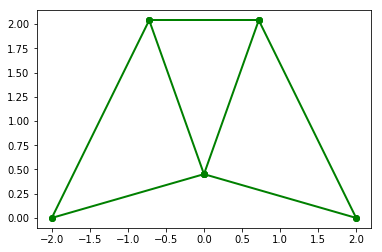

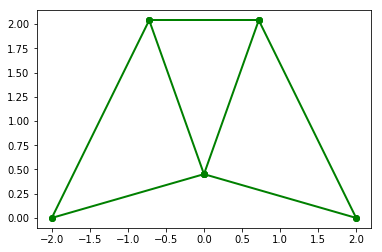

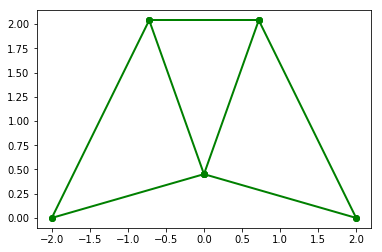

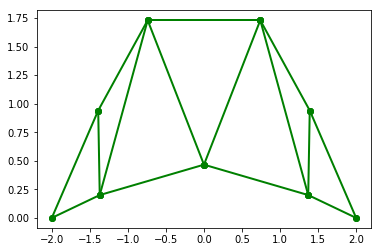

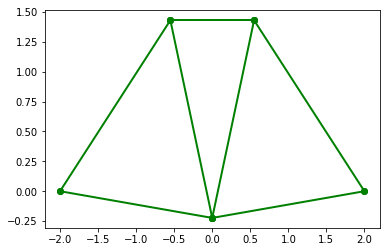

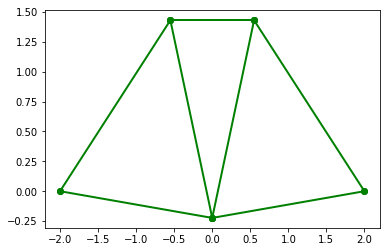

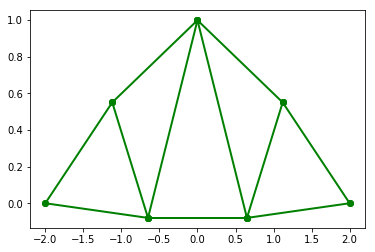

In [24]:
for truss in winning_truss_per_iteration:
    truss.draw_truss()

iteration 0


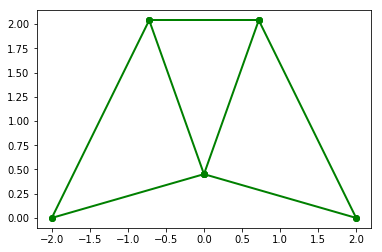

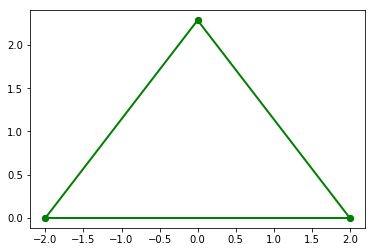

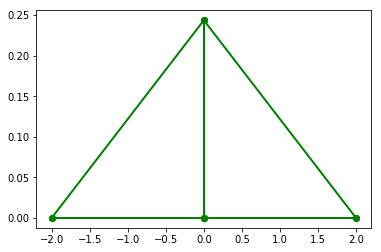

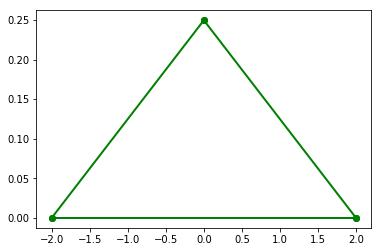

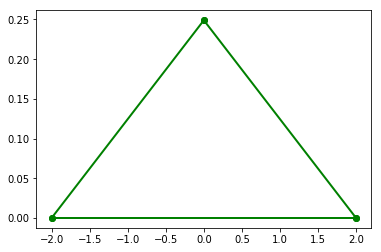

iteration 1


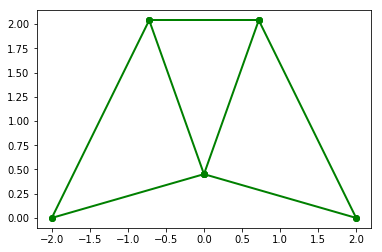

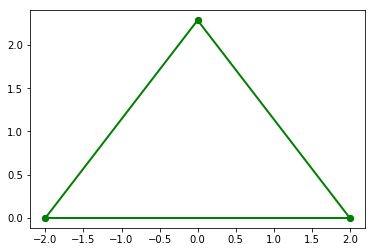

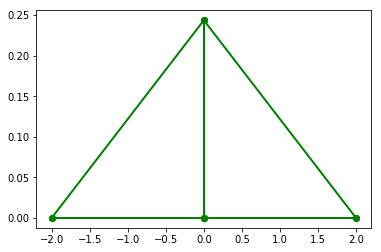

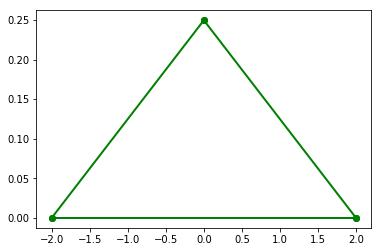

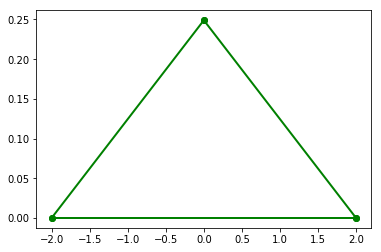

iteration 2


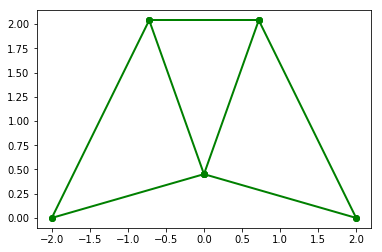

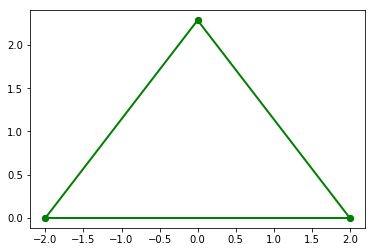

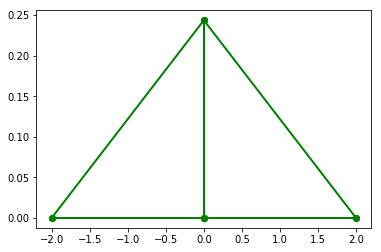

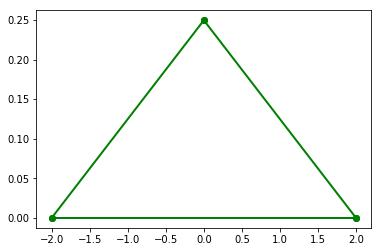

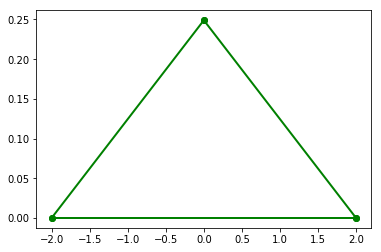

iteration 3


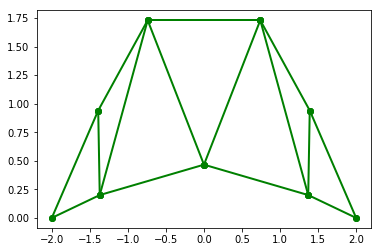

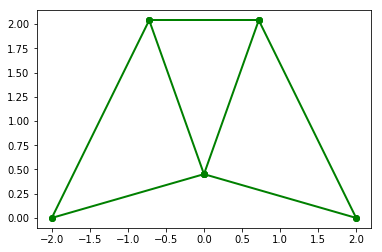

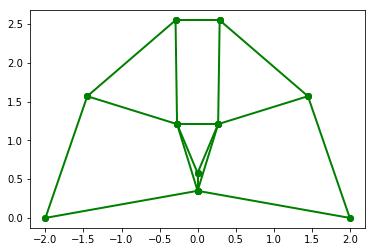

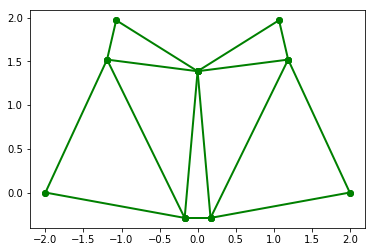

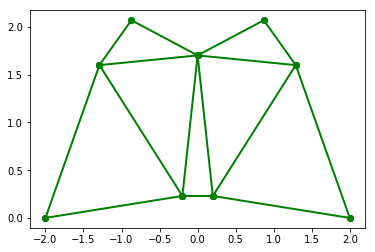

iteration 4


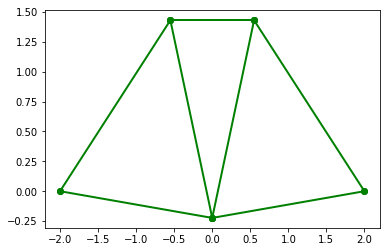

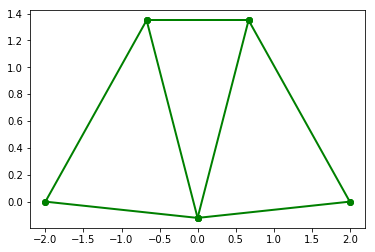

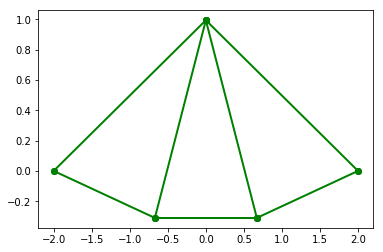

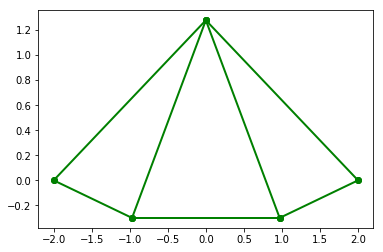

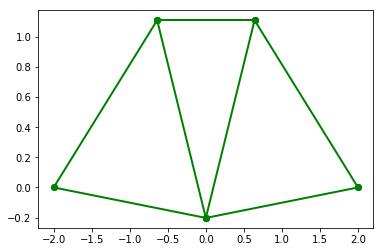

iteration 5


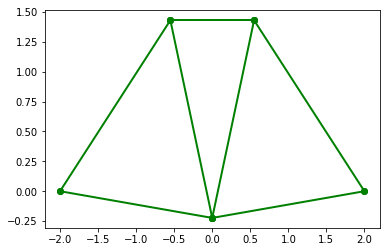

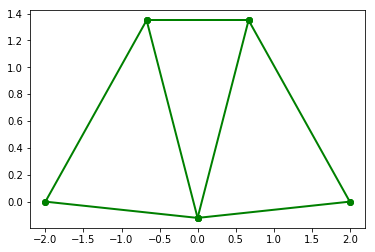

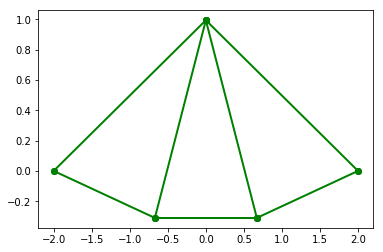

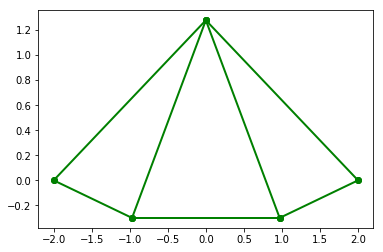

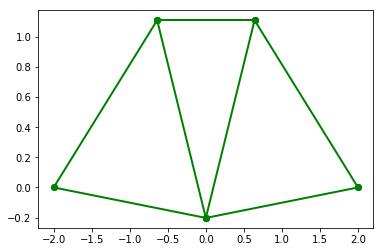

iteration 6


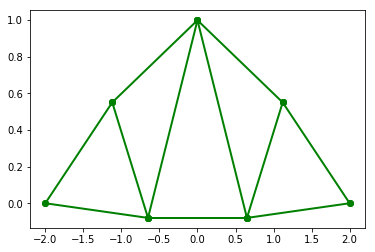

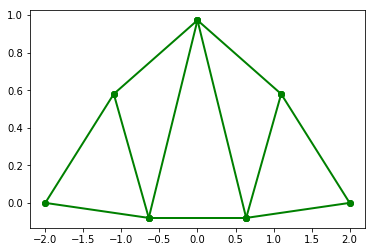

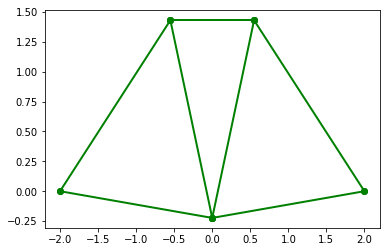

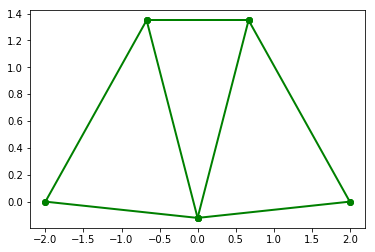

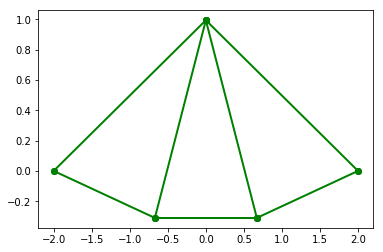

In [25]:
iteration = 0
for top_n in top_n_trusses_per_iteration:
    print("iteration", iteration)
    for tup in top_n:
        tup[0].draw_truss()
    iteration+=1